In [1]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt
import plyfile
import pandas
import cv2
from scipy.ndimage.filters import gaussian_filter1d
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from speed_regression import training_data as td
from speed_regression import regression
from speed_regression import regression_cascade

nano_to_sec = 1e09

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 10

In [3]:
option = td.TrainingDataOption()
extra_args = {'feature_smooth_sigma': 2.0,
              'target_smooth_sigma': 30.0}
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

In [2]:
model_path = '../../models/svr_cascade1023'
model = regression_cascade.load_model_from_file(model_path)

num_sv_classifier = model.classifier.getSupportVectors().shape[0]
num_sv_regressor = [reg.getSupportVectors().shape[0] for reg in model.regressors]
print('Number of supporting vectors: {}, {}'.format(num_sv_classifier, num_sv_regressor))
print('Total number of sv: ', num_sv_classifier + sum(num_sv_regressor))
print('Class map: ', model.class_map)

Number of supporting vectors: 12963, [4937, 5051, 9007, 9088, 7195, 7765, 9307, 8604]
Total number of sv:  73917
Class map:  {'bag': 2, 'body': 3, 'handheld': 0, 'leg': 1}


In [34]:
# load testing data
train_feature, train_label, train_responses, _ = regression_cascade.load_datalist('../../data2/list_train_allsub.txt',
                                                                                 option, model.class_map)

train_responses = train_responses[:, [0, 2]]

Loading dataset ../../data2/hang_handheld_speed1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_side1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_spin1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_stop1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_leg_normal1/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_speed1/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_side1/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_spin1/processed/data.csv, type: leg
Loading dataset ../../data2/hang_bag_normal1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_speed1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_side1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_spin1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_stop1/processed/data.csv, type: bag
Load

In [37]:
test_feature, test_label, test_responses, _ = regression_cascade.load_datalist('../../data2/list_test_allsub.txt',
                                                                              option, model.class_map)
test_responses = test_responses[:, [0, 2]]
feature_classes = [test_feature[test_label==cls].astype(np.float32)
                   for cls in model.class_map.values()]
response_classes = [test_responses[test_label==cls].astype(np.float32)
                    for cls in model.class_map.values()]

Loading dataset ../../data2/hang_handheld_normal2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_speed2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_side2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_spin2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_leg_normal2/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_speed2/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_side2/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_spin2/processed/data.csv, type: leg
Loading dataset ../../data2/hang_bag_normal2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_speed2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_side2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_spin2/processed/data.csv, type: bag
Loading dataset ../../data2/huayi_handheld2/processed/data.csv, type: handh

In [35]:
# Test with the baseline model
channel_list = [0, 2]
predicted_all = [[], []]
gt_all = [[], []]
time_for_testing = 0
for i in range(2):
    regressor = cv2.ml.SVM_load('../../models/SVR_0918_c1e0001_w200_s10_{}.yml'.format(channel_list[i]))
    print('Model loaded')
    t = time.time()
    for cls in model.class_map.values():
        predicted = regressor.predict(feature_classes[cls])[1].ravel()
        # r2 = r2_score(predicted, response_classes[cls][:, chn])
        mse = mean_squared_error(predicted, response_classes[cls][:, i])
        print('Baseline, class %d, channel %d, score: %f(MSE)' % (cls, i, mse))
        predicted_all[i].append(predicted)
        gt_all[i].append(response_classes[cls][:, i])
    time_for_testing += time.time() - t
for i in range(2):
    predicted_all[i] = np.concatenate(predicted_all[i], axis=0)
    gt_all[i] = np.concatenate(gt_all[i], axis=0)
    mse = mean_squared_error(predicted_all[i], gt_all[i])
    print('Overall regression error for channel %d: %f(MSE)' % (i, mse))
print('Time usage: ', time_for_testing)

Model loaded
Baseline, class 3, channel 0, score: 0.004384(MSE)
Baseline, class 1, channel 0, score: 0.002860(MSE)
Baseline, class 0, channel 0, score: 0.002426(MSE)
Baseline, class 2, channel 0, score: 0.011348(MSE)
Model loaded
Baseline, class 3, channel 1, score: 0.003727(MSE)
Baseline, class 1, channel 1, score: 0.003131(MSE)
Baseline, class 0, channel 1, score: 0.004570(MSE)
Baseline, class 2, channel 1, score: 0.010549(MSE)
Overall regression error for channel 0: 0.005397(MSE)
Overall regression error for channel 1: 0.005622(MSE)
Time usage:  252.46116948127747


In [40]:
## Training error
t = time.time()
print('Training error')
label_predicted_on_train, response_predicted_on_train = model.test(train_feature, train_label, train_responses)
print('Time usage: ', time.time() - t)

Training error
Classification accuracy:  0.948334395802
Error for class 0, channel 0: 0.931190(R2), 0.005597(MSE)
Error for class 0, channel 1: 0.959532(R2), 0.006119(MSE)
Error for class 1, channel 0: 0.996281(R2), 0.000370(MSE)
Error for class 1, channel 1: 0.997711(R2), 0.000244(MSE)
Error for class 2, channel 0: 0.993990(R2), 0.001047(MSE)
Error for class 2, channel 1: 0.988406(R2), 0.000837(MSE)
Error for class 3, channel 0: 0.952506(R2), 0.001303(MSE)
Error for class 3, channel 1: 0.995323(R2), 0.002132(MSE)
Overall regression error for channel 0: 0.995050(R2), 0.001923(MSE)
Overall regression error for channel 1: 0.994751(R2), 0.002319(MSE)
Time usage:  560.10458111763


In [38]:
t = time.time()
print('Testing error')
label_predicted, response_predicted = model.test(test_feature, test_label, test_responses)
print('Time usage: ', time.time() - t)

Testing error
Classification accuracy:  0.942531560719
Error for class 0, channel 0: 0.746958(R2), 0.021092(MSE)
Error for class 0, channel 1: 0.797969(R2), 0.019090(MSE)
Error for class 1, channel 0: 0.814414(R2), 0.012397(MSE)
Error for class 1, channel 1: 0.888841(R2), 0.010494(MSE)
Error for class 2, channel 0: 0.850916(R2), 0.012288(MSE)
Error for class 2, channel 1: 0.802866(R2), 0.013544(MSE)
Error for class 3, channel 0: 0.693424(R2), 0.006312(MSE)
Error for class 3, channel 1: 0.973246(R2), 0.008556(MSE)
Overall regression error for channel 0: 0.970126(R2), 0.014063(MSE)
Overall regression error for channel 1: 0.969580(R2), 0.013482(MSE)
Time usage:  275.7534210681915


Class map:  {'bag': 2, 'body': 3, 'handheld': 0, 'leg': 1}
[[14491     0    34   874]
 [   18 13644    24   866]
 [    3     9  8099   694]
 [   34     0    16  5949]]
Accuracy:  0.942531560719
Confusion_normalized
 [[  3.23785052e-01   0.00000000e+00   7.59691655e-04   1.95285443e-02]
 [  4.02189699e-04   3.04859792e-01   5.36252933e-04   1.93497933e-02]
 [  6.70316166e-05   2.01094850e-04   1.80963021e-01   1.55066473e-02]
 [  7.59691655e-04   0.00000000e+00   3.57501955e-04   1.32923696e-01]]


<IPython.core.display.Javascript object>


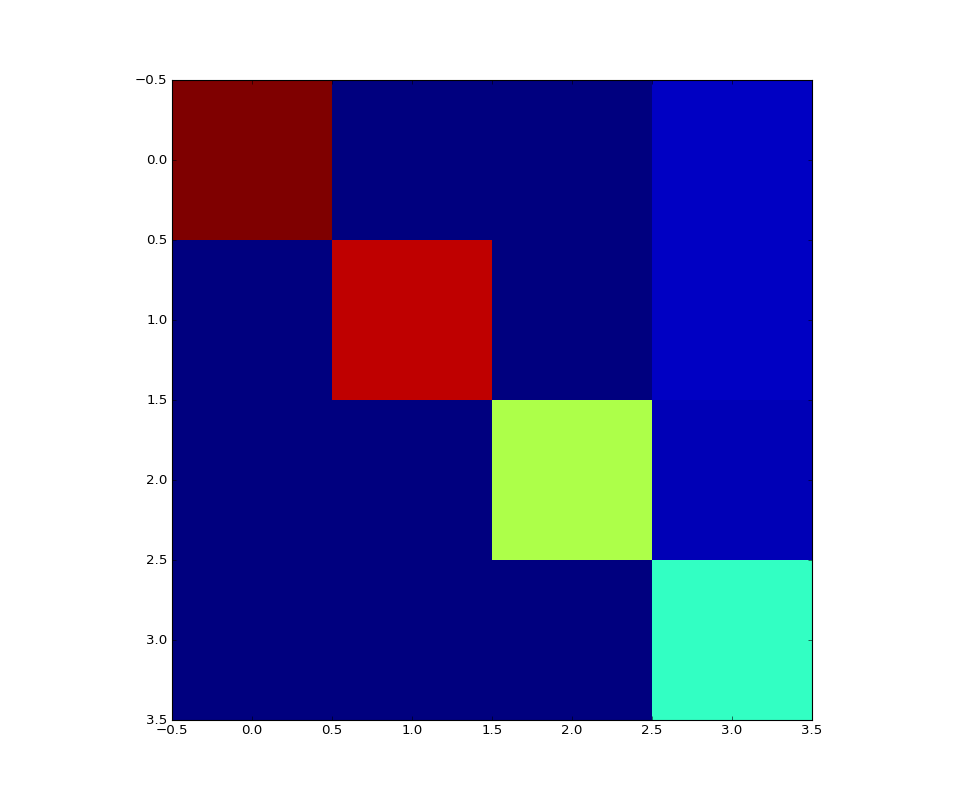

In [49]:
# Compute the confusion matrix. 
# confusion_matrix[i, j] means the number of samples with the class i predicted as the class j.
num_classes = model.num_classes
confusion_matrix = np.zeros([num_classes, num_classes], dtype=np.int)
for i in range(label_predicted.shape[0]):
    confusion_matrix[test_label[i], int(label_predicted[i])] += 1
print('Class map: ', model.class_map)
print(confusion_matrix)
# The classification accuracy is the sum of the diagonal elements divided by the sum of the whole matrix. Make sure
# this number matches the testing accuracy.
accuracy = np.sum(np.diagonal(confusion_matrix).astype(np.float)) / np.sum(confusion_matrix).astype(np.float)
print('Accuracy: ', accuracy)

# Draw the confusion matrix
confusion_matrix = confusion_matrix.astype(float) / label_predicted.shape[0]
print('Confusion_normalized\n', confusion_matrix)

plt.imshow(confusion_matrix, interpolation='nearest')

In [12]:
# test with the unseen subject
feature_yajie, label_yajie, response_yajie, _ = regression_cascade.load_datalist('../../data2/list_yajie.txt', 
                                                                              option, model.class_map)
response_yajie = response_yajie[:, [0, 2]]

Loading dataset ../../data2/yajie_handheld1/processed/data.csv, type: handheld
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/yajie_handheld2/processed/data.csv, type: handheld
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/yajie_leg1/processed/data.csv, type: leg
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/yajie_leg2/processed/data.csv, type: leg
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/yajie_bag1/processed/data.csv, type: bag
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/yajie_body1/processed/data.csv, type: body
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/ya

In [13]:
predicted_label_yajie, predicted_response_yajie = model.test(feature_yajie, label_yajie, response_yajie)

Classification accuracy:  0.897915224248
Error for class 0, channel 0: 0.281345(R2), 0.027298(MSE)
Error for class 0, channel 1: 0.863059(R2), 0.038440(MSE)
Error for class 1, channel 0: 0.552622(R2), 0.026582(MSE)
Error for class 1, channel 1: 0.180778(R2), 0.039887(MSE)
Error for class 2, channel 0: 0.755117(R2), 0.024757(MSE)
Error for class 2, channel 1: -0.518187(R2), 0.039353(MSE)
Error for class 3, channel 0: 0.147359(R2), 0.026100(MSE)
Error for class 3, channel 1: 0.836543(R2), 0.012335(MSE)
Overall regression error for channel 0: 0.926864(R2), 0.026610(MSE)
Overall regression error for channel 1: 0.882330(R2), 0.033906(MSE)


In [30]:
# Analyze the model
dummy_feature = test_feature[0, :]
sv_classification = model.classifier.getSupportVectors()
dim = sv_classification.shape[1]

dtype = {'names': ['f{}'.format(i) for i in range(dim)],
        'formats': dim * [sv_classification.dtype]}

num_shared_sv = 0
for cls in range(model.num_classes):
    sum_cls = 0
    for chn in range(model.num_channels):
        sv_regressor = model.regressors[cls * model.num_channels + chn].getSupportVectors()
        inter = np.intersect1d(sv_classification.view(dtype), sv_regressor.view(dtype))
        print('Number of shared SV for class {}, channel {}: {}'.format(cls, chn, inter.shape[0]))
        sum_cls += inter.shape[0]
        num_shared_sv += inter.shape[0]
    print('Shared SV for class {}: {}'.format(cls, sum_cls))
print('Unshared SV: ', sv_classification.shape[0] - num_shared_sv)
print('Total number of shared sv: {:d}, ratio: {:f}'.format(num_shared_sv, num_shared_sv
                                                            / sv_classification.shape[0]))

Number of shared SV for class 0, channel 0: 951
Number of shared SV for class 0, channel 1: 1323
Shared SV for class 0: 2274
Number of shared SV for class 1, channel 0: 2025
Number of shared SV for class 1, channel 1: 2036
Shared SV for class 1: 4061
Number of shared SV for class 2, channel 0: 1226
Number of shared SV for class 2, channel 1: 1151
Shared SV for class 2: 2377
Number of shared SV for class 3, channel 0: 1134
Number of shared SV for class 3, channel 1: 1222
Shared SV for class 3: 2356
Unshared SV:  301
Total number of shared sv: 11068, ratio: 0.973524


Error for class 3, channel 0: 0.904478(R2), 0.004513(MSE)
Error for class 3, channel 1: 0.982236(R2), 0.015811(MSE)
Overall regression error for channel 0: 0.904478(R2), 0.004513(MSE)
Overall regression error for channel 1: 0.982236(R2), 0.015811(MSE)


<IPython.core.display.Javascript object>


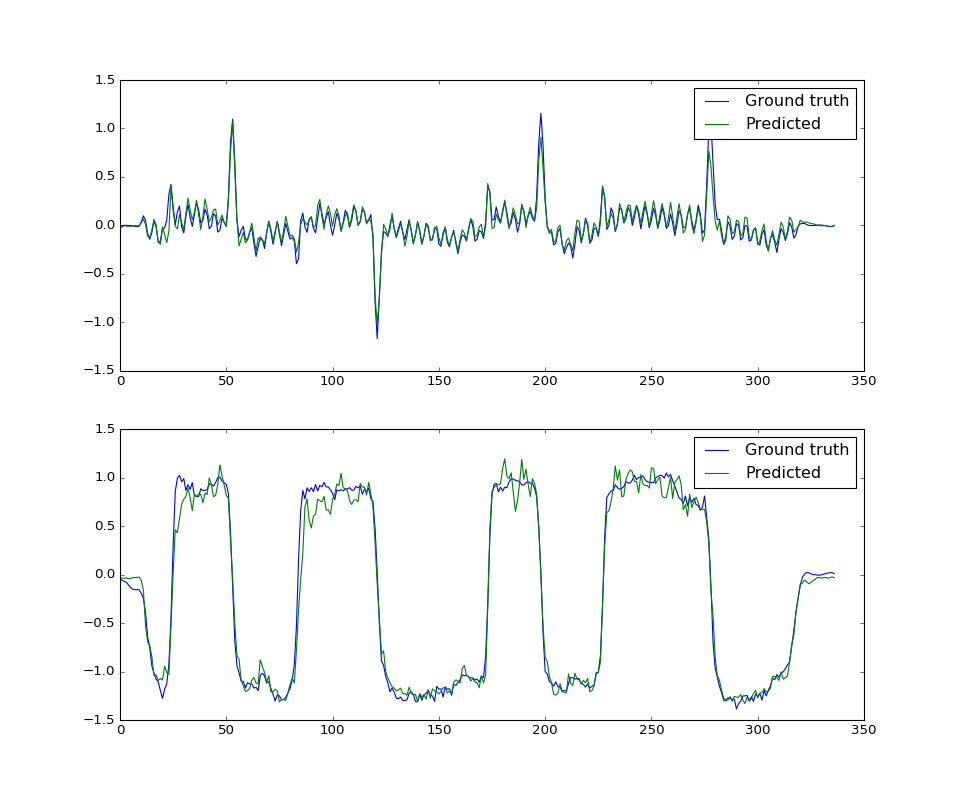

In [35]:
# Load a single dataset and plot the speed
data_single = pandas.read_csv('../../data2/hang_body_backward2/processed/data.csv')
t = data_single['time']
option2 = td.TrainingDataOption(sample_step=50)
# sample_points = np.arange(option.window_size_, t.shape[0] - 1, 50)
feature, response = td.get_training_data(data_all=data_single, imu_columns=imu_columns, option=option2, 
                                         extra_args=extra_args)
response = response[:, [0, 2]]
label_single, response_single = model.test(feature, None, response)
plt.figure('Regression')
for i in range(2):
    plt.subplot(211 + i)
    plt.plot(response[:, i])
    plt.plot(response_single[:, i])
    plt.legend(['Ground truth', 'Predicted'])